In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
import pyro.infer
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import os

pyro.set_rng_seed(42)
torch.manual_seed(42)
np.random.seed(42)

uplink_file = "./data/processed/processed_uplink_all.csv"
uplink_df = pd.read_csv(uplink_file)

print(f"Loaded {len(uplink_df)} rows from {uplink_file}")
print(uplink_df.columns)
uplink_df.head()

Loaded 608969 rows from ./data/processed/processed_uplink_all.csv
Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'app_name', 'file_name', 'timestamp', 'direction', 'inter_arrival_time',
       'inter_arrival_ms'],
      dtype='object')


,No.,Time,Source,Destination,Protocol,Length,Info,app_name,file_name,timestamp,direction,inter_arrival_time,inter_arrival_ms
0,3,2022-08-09 23:30:02.323707,10.215.173.1,10.215.173.2,DNS,66,Standard query 0x02cd A sdk.iad-05.braze.com,Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.323707,uplink,0 days 00:00:00.048427,48.427
1,5,2022-08-09 23:30:02.384281,10.215.173.1,54.83.54.153,TCP,60,39730 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.384281,uplink,0 days 00:00:00.060574,60.574
2,7,2022-08-09 23:30:02.404822,10.215.173.1,146.75.50.133,TCP,60,36154 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.404822,uplink,0 days 00:00:00.020541,20.541
3,8,2022-08-09 23:30:02.415037,10.215.173.1,146.75.50.133,TCP,60,36156 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.415037,uplink,0 days 00:00:00.010215,10.215
4,10,2022-08-09 23:30:02.446043,10.215.173.1,146.75.50.133,TCP,40,36154 > 443 [ACK] Seq=1 Ack=1 Win=79872 Len=0,Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.446043,uplink,0 days 00:00:00.031006,31.006


# Only inter_arrival_time

Original data points: 608969
Filtered data points: 578520
Mean: 62.62 ms, Median: 9.72 ms
Min: 0.00 ms, Max: 876.72 ms


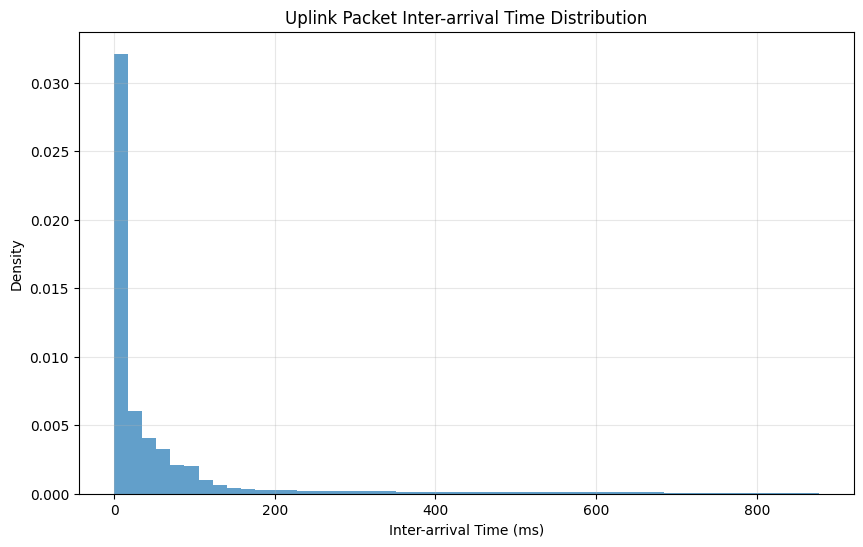

In [3]:
# Extract and prepare the data
if 'inter_arrival_ms' in uplink_df.columns:
    inter_arrival_times = uplink_df['inter_arrival_ms'].dropna().values
elif 'inter_arrival_time' in uplink_df.columns:
    try:
        inter_arrival_times = pd.to_numeric(uplink_df['inter_arrival_time']).values
    except:
        def convert_timedelta_to_ms(td_str):
            if isinstance(td_str, (int, float)):
                return float(td_str)
            try:
                parts = td_str.split()
                if len(parts) >= 3:
                    days = int(parts[0])
                    time_parts = parts[2].split(':')
                    hours = int(time_parts[0])
                    minutes = int(time_parts[1])
                    seconds = float(time_parts[2])
                    
                    total_ms = (days*86400 + hours*3600 + minutes*60 + seconds) * 1000
                    return total_ms
                else:
                    return float(td_str)
            except:
                return np.nan
        
        uplink_df['inter_arrival_ms'] = uplink_df['inter_arrival_time'].apply(convert_timedelta_to_ms)
        inter_arrival_times = uplink_df['inter_arrival_ms'].dropna().values
else:
    print("Error: No inter-arrival time column found in the data")
    
# Filter out extreme values
threshold = np.percentile(inter_arrival_times, 95)
filtered_data = inter_arrival_times[inter_arrival_times < threshold]
print(f"Original data points: {len(inter_arrival_times)}")
print(f"Filtered data points: {len(filtered_data)}")
print(f"Mean: {np.mean(filtered_data):.2f} ms, Median: {np.median(filtered_data):.2f} ms")
print(f"Min: {np.min(filtered_data):.2f} ms, Max: {np.max(filtered_data):.2f} ms")

data_tensor = torch.tensor(filtered_data, dtype=torch.float)

plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=50, density=True, alpha=0.7)
plt.title("Uplink Packet Inter-arrival Time Distribution")
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.show()

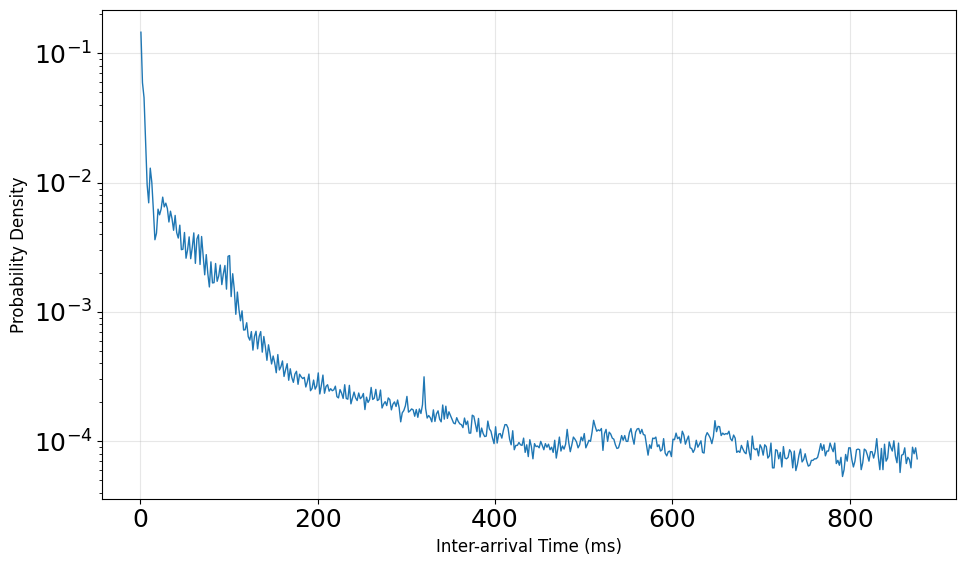

In [17]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 6))
counts, bin_edges = np.histogram(filtered_data, bins=500, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.semilogy(bin_centers, counts, linewidth=1)
plt.xlabel("Inter-arrival Time (ms)", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
#plt.show()
plt.savefig("mv_ul_traffic.png")

In [5]:
# Exponential
def exponential_model(data=None):
    rate = pyro.sample("rate", dist.Gamma(1.0, 1.0))
    with pyro.plate("data", len(data) if data is not None else 1):
        return pyro.sample("obs", dist.Exponential(rate), obs=data)

# Gamma Model
def gamma_model(data=None):
    alpha = pyro.sample("alpha", dist.Gamma(1.0, 1.0))
    beta = pyro.sample("beta", dist.Gamma(1.0, 1.0))
    with pyro.plate("data", len(data) if data is not None else 1):
        return pyro.sample("obs", dist.Gamma(alpha, beta), obs=data)

Running MAP for Exponential model...
Step 0: loss = 35552336.0000
Step 100: loss = 130652880.0000
Step 200: loss = 7039262.0000
Step 300: loss = 4189997.7500
Step 400: loss = 55433828.0000
Step 500: loss = 15417017.0000
Step 600: loss = 8291773.5000
Step 700: loss = 42042532.0000
Step 800: loss = 41802860.0000
Step 900: loss = 13990959.0000
Step 1000: loss = 26257120.0000
Step 1100: loss = 4610732.0000
Step 1200: loss = 43109208.0000
Step 1300: loss = 22252886.0000
Step 1400: loss = 12431018.0000
Step 1500: loss = 37814788.0000
Step 1600: loss = 47982860.0000
Step 1700: loss = 93958792.0000
Step 1800: loss = 49283684.0000
Step 1900: loss = 19122144.0000
Step 2000: loss = 17344872.0000
Step 2100: loss = 17153742.0000
Step 2200: loss = 67065968.0000
Step 2300: loss = 17828190.0000
Step 2400: loss = 22047848.0000
Step 2500: loss = 51138080.0000
Step 2600: loss = 60409144.0000
Step 2700: loss = 29783588.0000
Step 2800: loss = 28922068.0000
Step 2900: loss = 3883685.2500
Step 3000: loss = 1

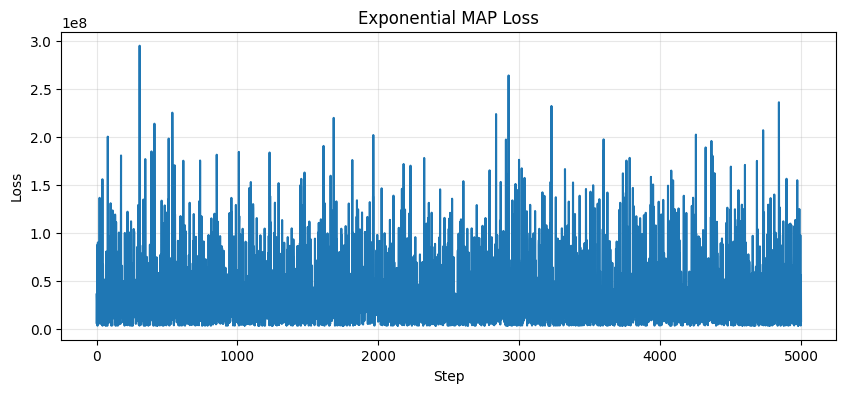

Running MAP for Gamma model...
Step 0: loss = 17087844.0000
Step 100: loss = 7184024.0000
Step 200: loss = 42187436.0000
Step 300: loss = 15972179.0000
Step 400: loss = 60882716.0000
Step 500: loss = 43696300.0000
Step 600: loss = 101973304.0000
Step 700: loss = 38143608.0000
Step 800: loss = 52824404.0000
Step 900: loss = 18679036.0000
Step 1000: loss = 16930010.0000
Step 1100: loss = 24034296.0000
Step 1200: loss = 40083876.0000
Step 1300: loss = 5678515.5000
Step 1400: loss = 2948664.5000
Step 1500: loss = 9184906.0000
Step 1600: loss = 3512812.0000
Step 1700: loss = 12633041.0000
Step 1800: loss = 7579813.0000
Step 1900: loss = 48904248.0000
Step 2000: loss = 33118772.0000
Step 2100: loss = 20872284.0000
Step 2200: loss = 31950158.0000
Step 2300: loss = 30009590.0000
Step 2400: loss = 19496364.0000
Step 2500: loss = 33779688.0000
Step 2600: loss = 13434173.0000
Step 2700: loss = 2624498.0000
Step 2800: loss = 31481626.0000
Step 2900: loss = 4393836.5000
Step 3000: loss = 31110682.0

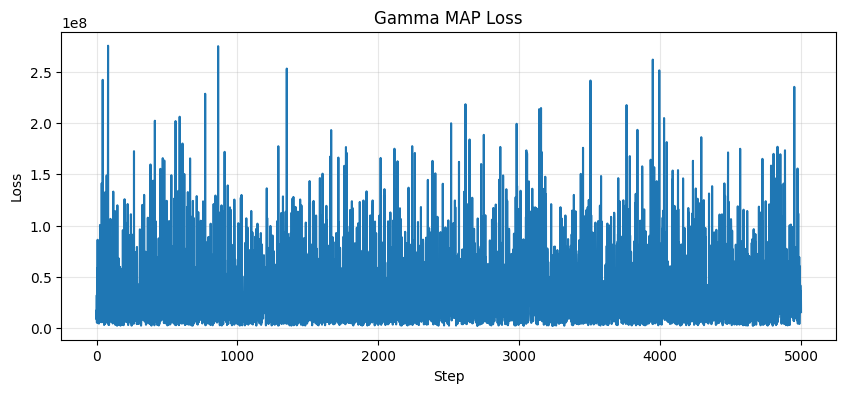

In [6]:
import pyro.infer.autoguide
def run_map(model, data, num_steps=5000):
    pyro.clear_param_store()
    auto_guide = pyro.infer.autoguide.AutoNormal(model)
    
    def map_loss(model, guide, data):
        trace = pyro.poutine.trace(model).get_trace(data)
        return -trace.log_prob_sum()
    
    optimizer = Adam({"lr": 0.01})
    svi = SVI(model, auto_guide, optimizer, loss=map_loss)
    
    losses = []
    for step in range(num_steps):
        loss = svi.step(data)
        losses.append(loss)
        if step % 100 == 0:
            print(f"Step {step}: loss = {loss:.4f}")
    
    posterior = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1000)
    posterior_samples = posterior(data)
    
    params = {}
    for param_name in posterior_samples:
        if param_name != "obs":
            params[param_name] = posterior_samples[param_name].mean().item()
    
    return params, losses

# MAP for Exponential model
print("Running MAP for Exponential model...")
exp_map_params, exp_map_losses = run_map(exponential_model, data_tensor, num_steps=5000)
print(f"Exponential MAP parameters: {exp_map_params}")
plt.figure(figsize=(10, 4))
plt.plot(exp_map_losses)
plt.title("Exponential MAP Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

# MAP for Gamma model
print("Running MAP for Gamma model...")
gamma_map_params, gamma_map_losses = run_map(gamma_model, data_tensor, num_steps=5000)
print(f"Gamma MAP parameters: {gamma_map_params}")
plt.figure(figsize=(10, 4))
plt.plot(gamma_map_losses)
plt.title("Gamma MAP Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

Running Variational Inference for Exponential model...
Step 0: ELBO loss = 30502328.8614
Step 100: ELBO loss = 16906212.6230
Step 200: ELBO loss = 8868414.2855
Step 300: ELBO loss = 7175559.0371
Step 400: ELBO loss = 5504302.4435
Step 500: ELBO loss = 4910760.6573
Step 600: ELBO loss = 3851617.9430
Step 700: ELBO loss = 3732045.2604
Step 800: ELBO loss = 3701991.9984
Step 900: ELBO loss = 3434251.8486
Step 1000: ELBO loss = 3383162.1263
Step 1100: ELBO loss = 3221037.0948
Step 1200: ELBO loss = 3114347.3201
Step 1300: ELBO loss = 3105114.5566
Step 1400: ELBO loss = 3085077.4489
Step 1500: ELBO loss = 3025941.7045
Step 1600: ELBO loss = 3017446.7562
Step 1700: ELBO loss = 3027322.5086
Step 1800: ELBO loss = 2997230.1616
Step 1900: ELBO loss = 2985503.0940
Step 2000: ELBO loss = 3003412.6120
Step 2100: ELBO loss = 2977255.6340
Step 2200: ELBO loss = 2978249.3335
Step 2300: ELBO loss = 2973107.2732
Step 2400: ELBO loss = 2986540.8206
Step 2500: ELBO loss = 2974722.8744
Step 2600: ELBO los

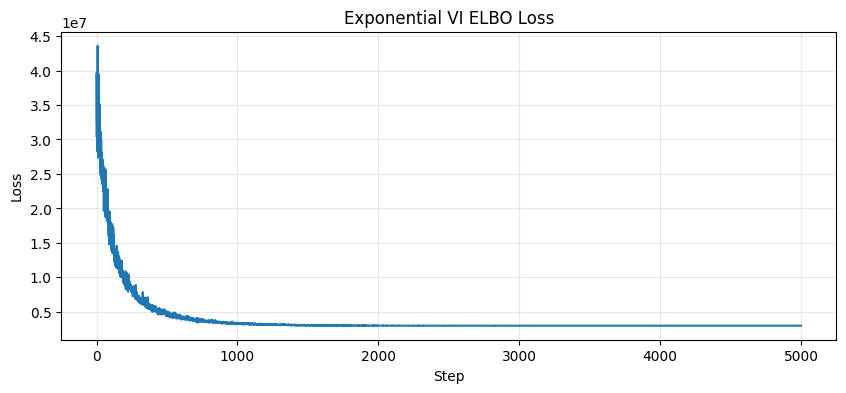

Running Variational Inference for Gamma model...
Step 0: ELBO loss = 33109162.3476
Step 100: ELBO loss = 15387851.5678
Step 200: ELBO loss = 10853151.5623
Step 300: ELBO loss = 7222381.8073
Step 400: ELBO loss = 5925378.5829
Step 500: ELBO loss = 4969829.9480
Step 600: ELBO loss = 4043319.3604
Step 700: ELBO loss = 3774805.7653
Step 800: ELBO loss = 3632047.2709
Step 900: ELBO loss = 3253862.5508
Step 1000: ELBO loss = 3072838.9144
Step 1100: ELBO loss = 3063053.2030
Step 1200: ELBO loss = 2900262.9807
Step 1300: ELBO loss = 2861030.5684
Step 1400: ELBO loss = 2753411.8704
Step 1500: ELBO loss = 2764274.9610
Step 1600: ELBO loss = 2723550.1303
Step 1700: ELBO loss = 2686848.1860
Step 1800: ELBO loss = 2665157.2440
Step 1900: ELBO loss = 2640900.5834
Step 2000: ELBO loss = 2614044.4077
Step 2100: ELBO loss = 2578767.7996
Step 2200: ELBO loss = 2577386.4779
Step 2300: ELBO loss = 2559908.6650
Step 2400: ELBO loss = 2541275.3928
Step 2500: ELBO loss = 2553898.7541
Step 2600: ELBO loss = 2

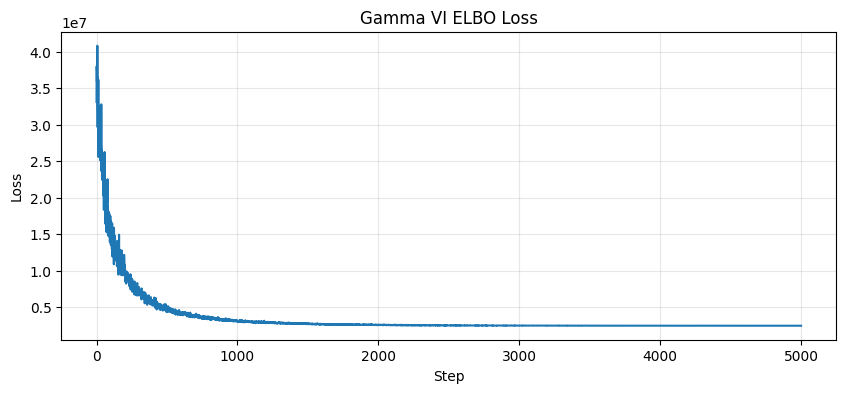

In [7]:
def run_vi(model, data, guide_type="auto", num_steps=5000):
    pyro.clear_param_store()
    if guide_type == "auto":
        guide = pyro.infer.autoguide.AutoNormal(model)
    elif guide_type == "mean_field":
        guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
    elif guide_type == "lowrank":
        guide = pyro.infer.autoguide.AutoLowRankMultivariateNormal(model)
    else:
        raise ValueError(f"Unknown guide type: {guide_type}")
    
    # Setup SVI
    optimizer = Adam({"lr": 0.01})
    elbo = Trace_ELBO()
    svi = SVI(model, guide, optimizer, loss=elbo)
    
    losses = []
    for step in range(num_steps):
        loss = svi.step(data)
        losses.append(loss)
        if step % 100 == 0:
            print(f"Step {step}: ELBO loss = {loss:.4f}")
    posterior = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
    posterior_samples = posterior(data)
    
    params = {}
    for param_name in posterior_samples:
        if param_name != "obs":
            params[param_name] = posterior_samples[param_name].mean(dim=0)
    return guide, posterior_samples, params, losses

# VI for Exponential model
print("Running Variational Inference for Exponential model...")
exp_guide, exp_posterior, exp_vi_params, exp_vi_losses = run_vi(
    exponential_model, data_tensor, guide_type="auto", num_steps=5000
)
print(f"Exponential VI parameters: {exp_vi_params}")
plt.figure(figsize=(10, 4))
plt.plot(exp_vi_losses)
plt.title("Exponential VI ELBO Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

# VI for Gamma model
print("Running Variational Inference for Gamma model...")
gamma_guide, gamma_posterior, gamma_vi_params, gamma_vi_losses = run_vi(
    gamma_model, data_tensor, guide_type="auto", num_steps=5000
)
print(f"Gamma VI parameters: {gamma_vi_params}")
plt.figure(figsize=(10, 4))
plt.plot(gamma_vi_losses)
plt.title("Gamma VI ELBO Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.item()}")

AutoNormal.locs.alpha: -1.1888865232467651
AutoNormal.scales.alpha: 0.011898262426257133
AutoNormal.locs.beta: -5.283752918243408
AutoNormal.scales.beta: 0.05774431303143501


Parameters for exponential: {'rate': 1.009737253189087}


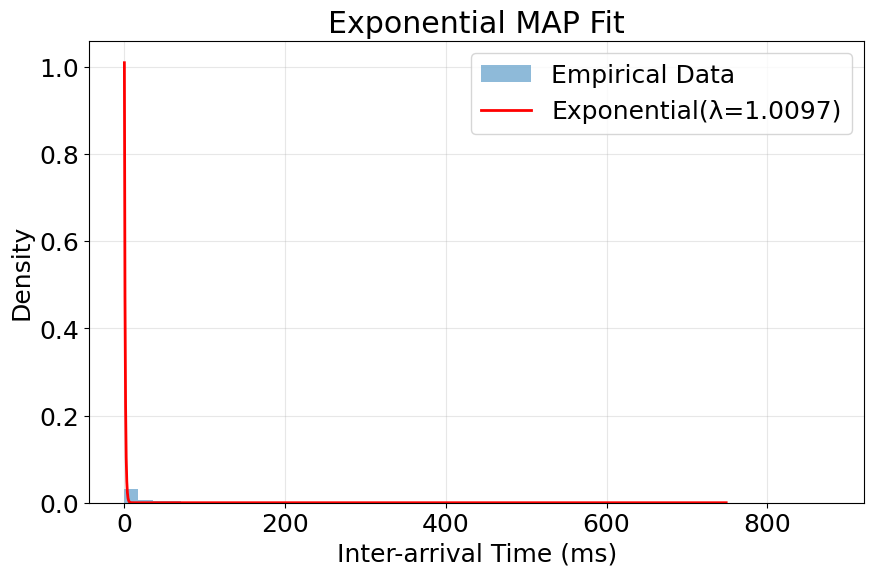

Parameters for gamma: {'alpha': 1.005839467048645, 'beta': 1.0032048225402832}


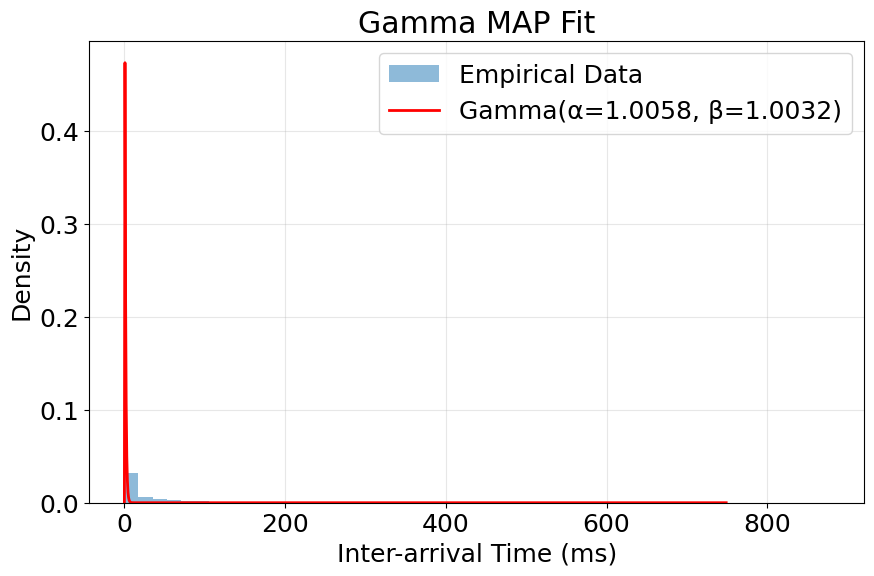

Parameters for exponential: {'rate': tensor([0.0159])}


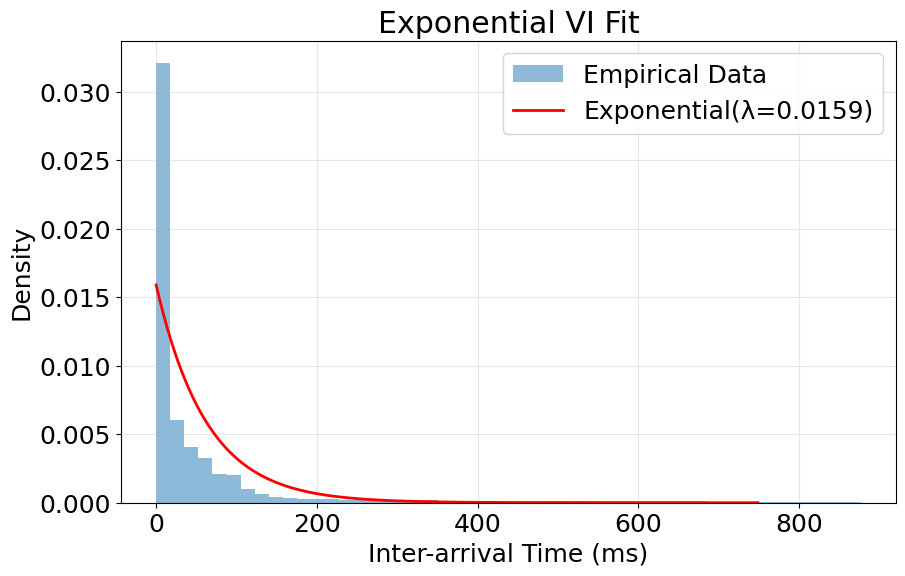

Parameters for gamma: {'alpha': tensor([0.3046]), 'beta': tensor([0.0051])}


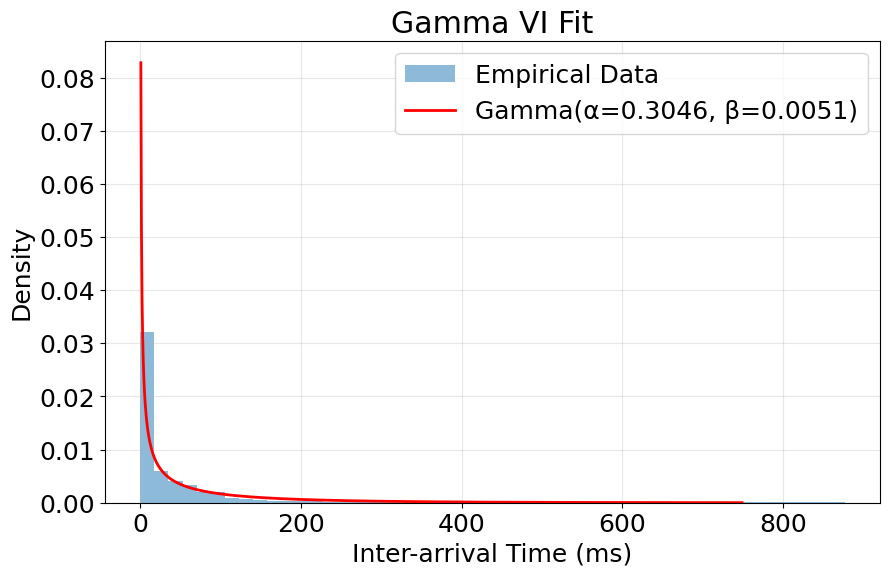


KL Divergence (lower is better):
Exponential MAP: 4.318949
Gamma MAP: 4.347519
Exponential VI: 0.446433
Gamma VI: 0.138380

Best model: Gamma VI with KL Divergence: 0.138380


In [15]:
from scipy import stats

def plot_distribution_fit(data, model_name, params, title=None):
    plt.figure(figsize=(10, 6))
    # Plot empirical histogram
    plt.hist(data.numpy(), bins=50, density=True, alpha=0.5, label='Empirical Data')
    
    # Plot the fitted distribution
    x = np.linspace(0, np.percentile(data.numpy(), 99), 1000)
    print(f"Parameters for {model_name}: {params}")
    if model_name == "exponential":
        rate = params["rate"]
        if torch.is_tensor(rate):
            rate = rate.item()
        y = stats.expon.pdf(x, scale=1/rate)
        dist_label = f"Exponential(λ={rate:.4f})"
    elif model_name == "gamma":
        alpha = params["alpha"]
        beta = params["beta"]
        if torch.is_tensor(alpha):
            alpha = alpha.item()
        if torch.is_tensor(beta):
            beta = beta.item()
        y = stats.gamma.pdf(x, a=alpha, scale=1/beta)
        dist_label = f"Gamma(α={alpha:.4f}, β={beta:.4f})"
    
    plt.plot(x, y, 'r-', linewidth=2, label=dist_label)
    if title:
        plt.title(title)
    else:
        plt.title(f"{model_name.capitalize()} Distribution Fit")
    plt.xlabel("Inter-arrival Time (ms)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def compute_kl_divergence(data, model_name, params, num_bins=50):
    # Compute empirical histogram
    hist, bin_edges = np.histogram(data.numpy(), bins=num_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Compute theoretical PDF
    if model_name == "exponential":
        rate = params["rate"]
        if torch.is_tensor(rate):
            rate = rate.item()
        theoretical_pdf = stats.expon.pdf(bin_centers, scale=1/rate)
    elif model_name == "gamma":
        alpha = params["alpha"]
        beta = params["beta"]
        if torch.is_tensor(alpha):
            alpha = alpha.item()
        if torch.is_tensor(beta):
            beta = beta.item()
        theoretical_pdf = stats.gamma.pdf(bin_centers, a=alpha, scale=1/beta)

    epsilon = 1e-10
    p = hist + epsilon
    q = theoretical_pdf + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    kl_div = np.sum(p * np.log(p / q))
    return kl_div

# Plot MAP model fits
plot_distribution_fit(data_tensor, "exponential", exp_map_params, "Exponential MAP Fit")
plot_distribution_fit(data_tensor, "gamma", gamma_map_params, "Gamma MAP Fit")
# Plot VI model fits
plot_distribution_fit(data_tensor, "exponential", exp_vi_params, "Exponential VI Fit")
plot_distribution_fit(data_tensor, "gamma", gamma_vi_params, "Gamma VI Fit")
# Compute KL divergence for all models
exp_map_kl = compute_kl_divergence(data_tensor, "exponential", exp_map_params)
gamma_map_kl = compute_kl_divergence(data_tensor, "gamma", gamma_map_params)
exp_vi_kl = compute_kl_divergence(data_tensor, "exponential", exp_vi_params)
gamma_vi_kl = compute_kl_divergence(data_tensor, "gamma", gamma_vi_params)

print("\nKL Divergence (lower is better):")
print(f"Exponential MAP: {exp_map_kl:.6f}")
print(f"Gamma MAP: {gamma_map_kl:.6f}")
print(f"Exponential VI: {exp_vi_kl:.6f}")
print(f"Gamma VI: {gamma_vi_kl:.6f}")

all_kl = {
    "Exponential MAP": exp_map_kl,
    "Gamma MAP": gamma_map_kl,
    "Exponential VI": exp_vi_kl,
    "Gamma VI": gamma_vi_kl
}
best_model = min(all_kl.items(), key=lambda x: x[1])
print(f"\nBest model: {best_model[0]} with KL Divergence: {best_model[1]:.6f}")

In [11]:
all_kl = {
    "Exponential MAP": exp_map_kl,
    "Gamma MAP": gamma_map_kl,
    # "Exponential VI": exp_vi_kl,
    # "Gamma VI": gamma_vi_kl
}
best_model = min(all_kl.items(), key=lambda x: x[1])
print(f"\nBest model: {best_model[0]} with KL Divergence: {best_model[1]:.6f}")


Best model: Exponential MAP with KL Divergence: 4.318949


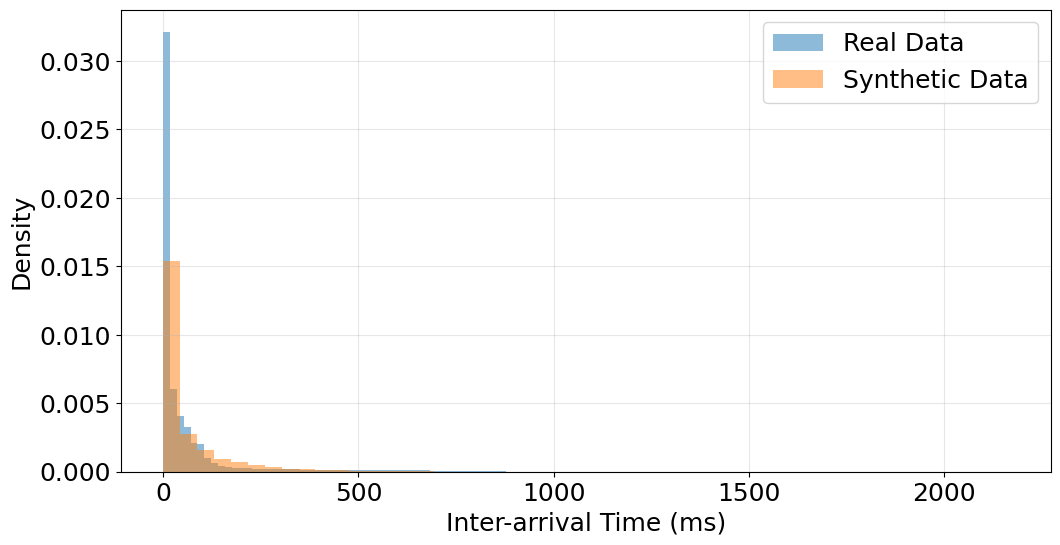

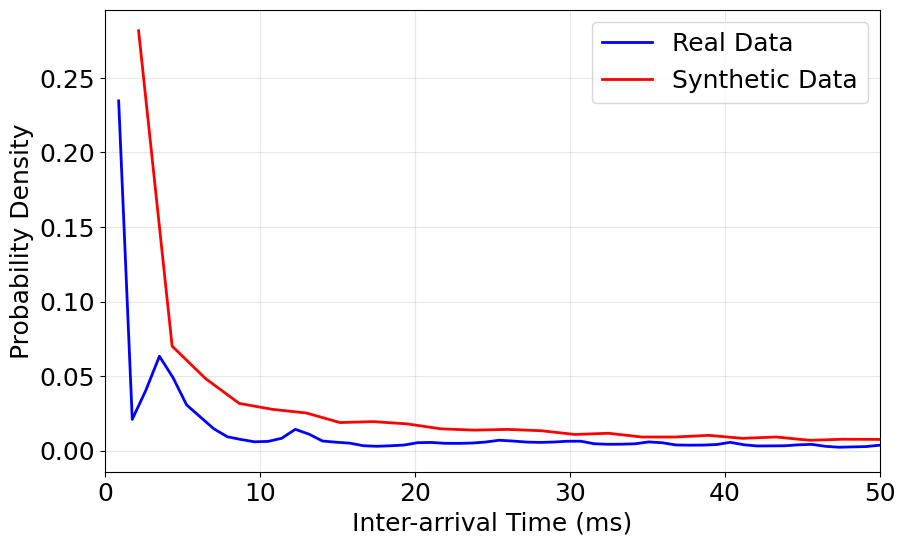

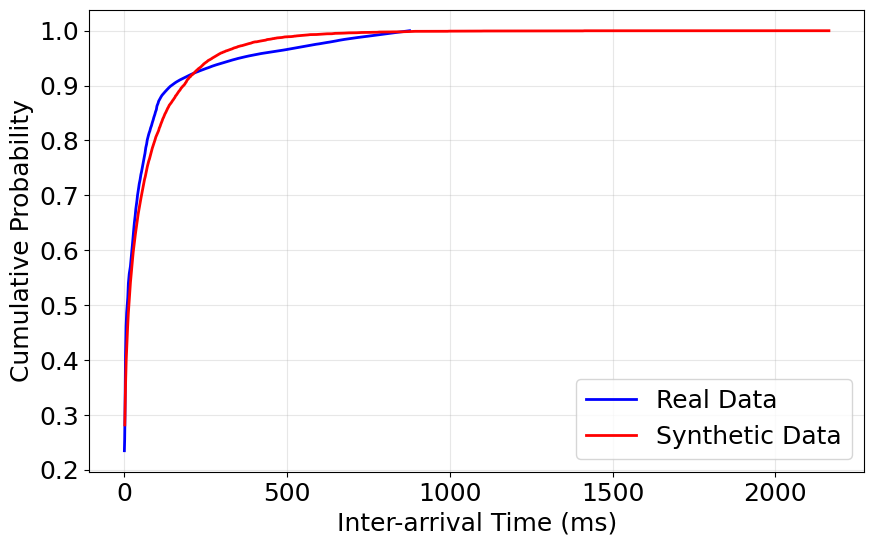

In [16]:
plt.rcParams.update({'font.size': 18})
def generate_synthetic_data(model_name, params, n_samples=10000):
    if model_name == "exponential":
        rate = params["rate"]
        synthetic_data = np.random.exponential(scale=1/rate, size=n_samples)
    elif model_name == "gamma":
        alpha = params["alpha"]
        beta = params["beta"]
        synthetic_data = np.random.gamma(shape=alpha, scale=1/beta, size=n_samples)
    
    return synthetic_data

# Generate synthetic data from the best model
model_name, method = best_model[0].split()
if method == "MAP":
    if model_name == "Exponential":
        best_params = exp_map_params
    else:
        best_params = gamma_map_params
else:
    if model_name == "Exponential":
        best_params = exp_vi_params
    else:
        best_params = gamma_vi_params

synthetic_data = generate_synthetic_data(model_name.lower(), best_params)

real_count, real_bins = np.histogram(filtered_data, bins=1000, density=True)
real_pdf = real_count / sum(real_count)
real_cdf = np.cumsum(real_pdf)
syn_count, syn_bins = np.histogram(synthetic_data, bins=1000, density=True)
syn_pdf = syn_count / sum(syn_count)
syn_cdf = np.cumsum(syn_pdf)

# Compare real vs synthetic data
plt.figure(figsize=(12, 6))
plt.hist(filtered_data, bins=50, alpha=0.5, density=True, label='Real Data')
plt.hist(synthetic_data, bins=50, alpha=0.5, density=True, label='Synthetic Data')
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# PDF comparison plot
plt.figure(figsize=(10, 6))
plt.plot(real_bins[1:], real_pdf, 'b-', linewidth=2, label='Real Data')
plt.plot(syn_bins[1:], syn_pdf, 'r-', linewidth=2, label='Synthetic Data')
plt.xlim([0, 50])  # Focus on the first 50ms
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)
#plt.show()
#plt.savefig("mv_ul_estmap_pdf.png")
plt.savefig("mv_ul_estvi_pdf.png")

# CDF
plt.figure(figsize=(10, 6))
plt.plot(real_bins[1:], real_cdf, 'b-', linewidth=2, label='Real Data')
plt.plot(syn_bins[1:], syn_cdf, 'r-', linewidth=2, label='Synthetic Data')
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True, alpha=0.3)
#plt.show()
#plt.savefig("mv_ul_estmap_cdf.png")
plt.savefig("mv_ul_estvi_cdf.png")

# Both pkt_size and inter_arrival_time

In [ ]:
if 'inter_arrival_ms' in uplink_df.columns and 'Length' in uplink_df.columns:
    inter_arrival_times = uplink_df['inter_arrival_ms'].dropna().values
    packet_sizes = uplink_df['Length'].dropna().values
    min_len = min(len(inter_arrival_times), len(packet_sizes))
    inter_arrival_times = inter_arrival_times[:min_len]
    packet_sizes = packet_sizes[:min_len]
else:
    print("Error: Required columns not found in the data")
    
iat_threshold = np.percentile(inter_arrival_times, 95)
filtered_indices = inter_arrival_times < iat_threshold
filtered_iat = inter_arrival_times[filtered_indices]
filtered_sizes = packet_sizes[filtered_indices]
data = torch.tensor(np.stack([filtered_iat, filtered_sizes], axis=1), dtype=torch.float)
iat_data = data[:, 0]
size_data = data[:, 1]

print(f"Prepared data shape: {data.shape}")
print(f"Inter-arrival time - Mean: {iat_data.mean().item():.2f} ms, Std: {iat_data.std().item():.2f} ms")
print(f"Packet size - Mean: {size_data.mean().item():.2f} bytes, Std: {size_data.std().item():.2f} bytes")

Prepared data shape: torch.Size([578520, 2])
Inter-arrival time - Mean: 62.62 ms, Std: 138.58 ms
Packet size - Mean: 62.85 bytes, Std: 100.41 bytes


In [ ]:
def model(pkt_size, iat=None):
    # Interarrival time: Gamma
    alpha = pyro.sample("alpha", dist.Gamma(1.0, 1.0))
    beta = pyro.sample("beta", dist.Gamma(1.0, 1.0))
    with pyro.plate("iat_data", len(iat) if iat is not None else 1):
        pyro.sample("iat_obs", dist.Gamma(alpha, beta), obs=iat)
    # Pkt size: LogNormal
    loc = pyro.sample("loc", dist.Normal(6.0, 1.0))
    scale = pyro.sample("scale", dist.LogNormal(0.0, 0.5))
    with pyro.plate("pkt_data", len(pkt_size) if pkt_size is not None else 1):
        pyro.sample("pkt_obs", dist.LogNormal(loc, scale), obs=pkt_size)
    return alpha, beta, loc, scale

Step 0: ELBO loss = 50782147.9186
Step 100: ELBO loss = 20390077.9409
Step 200: ELBO loss = 13907179.1991
Step 300: ELBO loss = 11214217.6156
Step 400: ELBO loss = 8693727.7267
Step 500: ELBO loss = 8121881.5096
Step 600: ELBO loss = 7489581.5905
Step 700: ELBO loss = 6911972.7896
Step 800: ELBO loss = 6576414.5857
Step 900: ELBO loss = 6289593.0130
Step 1000: ELBO loss = 6004718.8425
Step 1100: ELBO loss = 5750480.2438
Step 1200: ELBO loss = 5595243.5630
Step 1300: ELBO loss = 5575455.1220
Step 1400: ELBO loss = 5431805.0573
Step 1500: ELBO loss = 5420888.4312
Step 1600: ELBO loss = 5372894.4067
Step 1700: ELBO loss = 5356655.7104
Step 1800: ELBO loss = 5343952.4358
Step 1900: ELBO loss = 5267875.3054
Step 2000: ELBO loss = 5242056.2526
Step 2100: ELBO loss = 5230815.1754
Step 2200: ELBO loss = 5233827.0644
Step 2300: ELBO loss = 5213636.6538
Step 2400: ELBO loss = 5216244.3009
Step 2500: ELBO loss = 5204022.4072
Step 2600: ELBO loss = 5184108.0068
Step 2700: ELBO loss = 5167869.8821


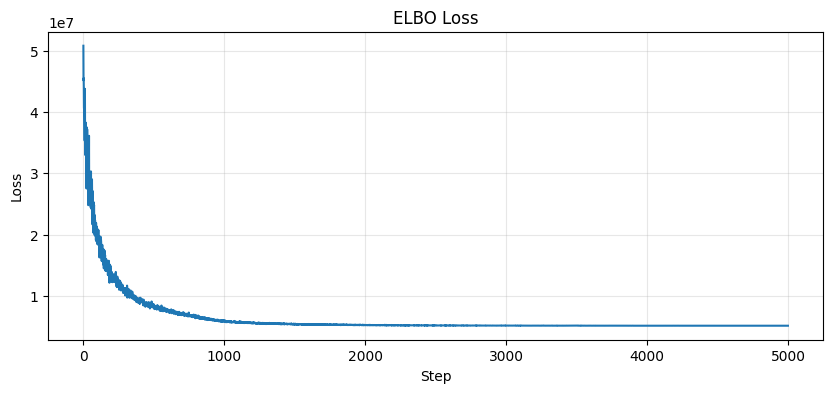

Trained parameters:
  alpha: 0.3092
  beta: 0.0051
  loc: 3.9498
  scale: 0.4586
  pkt_obs: 62.8462


In [ ]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)
pyro.clear_param_store()
adam = Adam({"lr": 0.01})
elbo = Trace_ELBO()
svi = SVI(model, auto_guide, adam, elbo)

losses = []
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(size_data, iat_data)
    losses.append(loss)
    if step % 100 == 0:
        print(f"Step {step}: ELBO loss = {loss:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("ELBO Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

posterior = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1000)
posterior_samples = posterior(size_data, iat_data)
params = {}
for param_name in posterior_samples:
    if param_name not in ["iat_obs", "size_obs"]:
        params[param_name] = posterior_samples[param_name].mean().item()
print("Trained parameters:")
for name, value in params.items():
    print(f"  {name}: {value:.4f}")

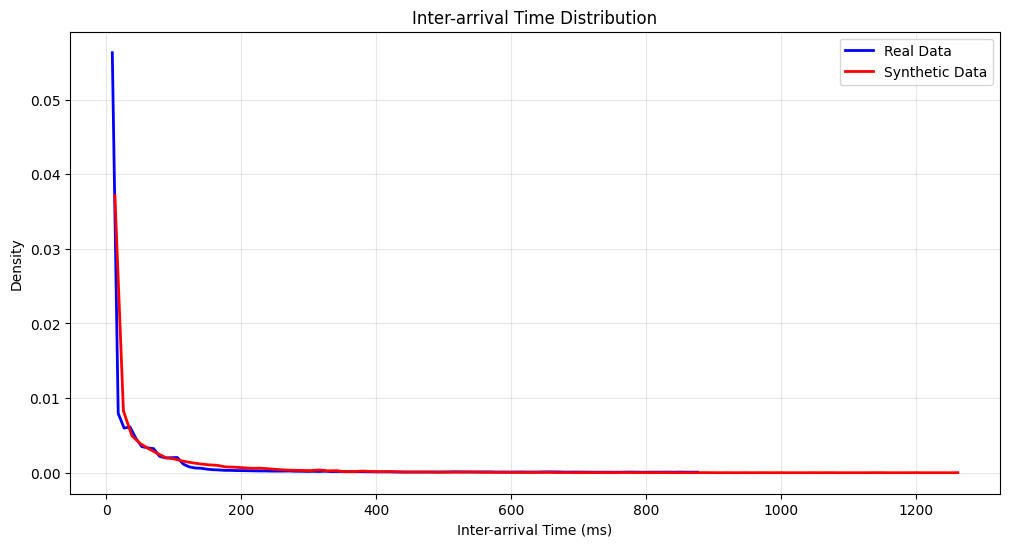

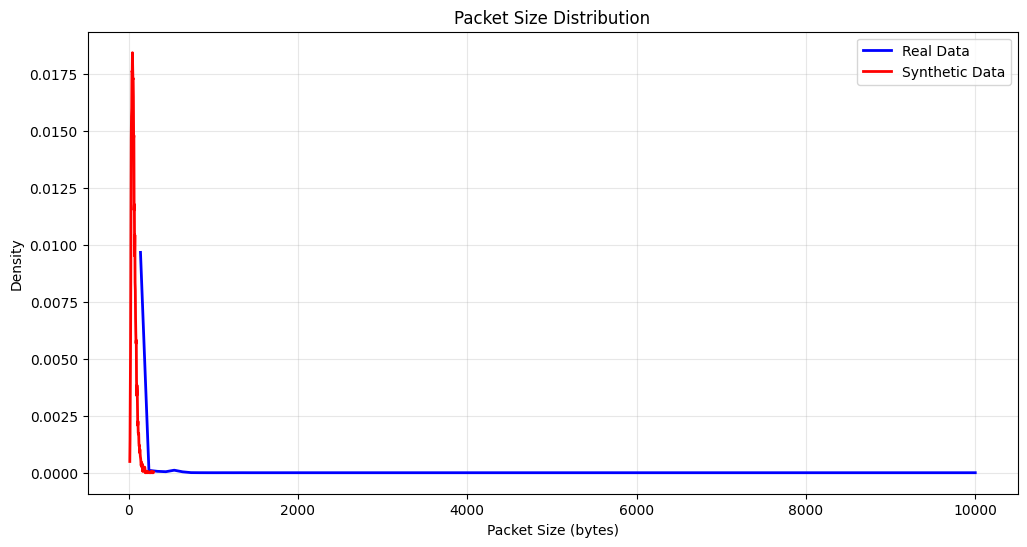

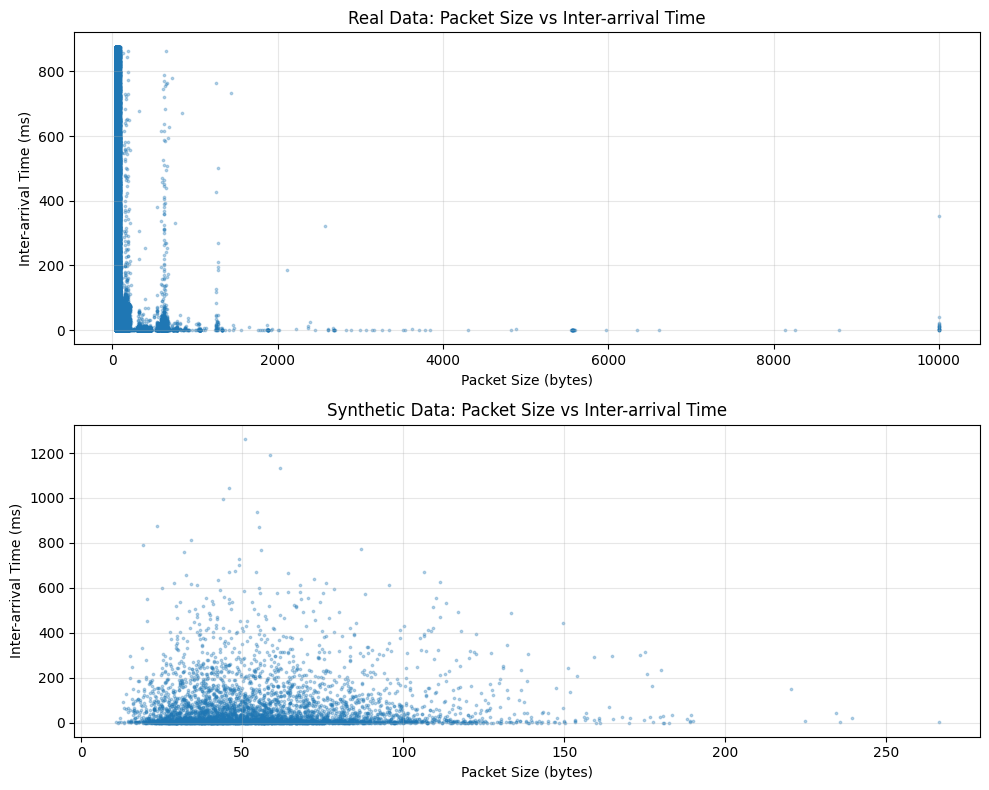

In [ ]:
def generate_synthetic_data(params, n_samples=10000):
    alpha = params["alpha"]
    beta = params["beta"]
    synthetic_iat = np.random.gamma(shape=alpha, scale=1/beta, size=n_samples)
    loc = params["loc"]
    scale = params["scale"]
    synthetic_size = np.random.lognormal(mean=loc, sigma=scale, size=n_samples)
    return synthetic_iat, synthetic_size

synthetic_iat, synthetic_size = generate_synthetic_data(params)
plt.figure(figsize=(12, 6))
real_iat_count, real_iat_bins = np.histogram(filtered_iat, bins=100, density=True)
syn_iat_count, syn_iat_bins = np.histogram(synthetic_iat, bins=100, density=True)

plt.plot(real_iat_bins[1:], real_iat_count, 'b-', linewidth=2, label='Real Data')
plt.plot(syn_iat_bins[1:], syn_iat_count, 'r-', linewidth=2, label='Synthetic Data')
plt.title("Inter-arrival Time Distribution")
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
real_size_count, real_size_bins = np.histogram(filtered_sizes, bins=100, density=True)
syn_size_count, syn_size_bins = np.histogram(synthetic_size, bins=100, density=True)

plt.plot(real_size_bins[1:], real_size_count, 'b-', linewidth=2, label='Real Data')
plt.plot(syn_size_bins[1:], syn_size_count, 'r-', linewidth=2, label='Synthetic Data')
plt.title("Packet Size Distribution")
plt.xlabel("Packet Size (bytes)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Joint distribution visualization
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.scatter(filtered_sizes, filtered_iat, alpha=0.3, s=3, label='Real Data')
plt.title("Real Data: Packet Size vs Inter-arrival Time")
plt.xlabel("Packet Size (bytes)")
plt.ylabel("Inter-arrival Time (ms)")
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.scatter(synthetic_size[:5000], synthetic_iat[:5000], alpha=0.3, s=3, label='Synthetic Data')
plt.title("Synthetic Data: Packet Size vs Inter-arrival Time")
plt.xlabel("Packet Size (bytes)")
plt.ylabel("Inter-arrival Time (ms)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()